In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import joblib


In [ ]:
data = pd.read_csv('/content/UNdata_Export_20250209_093711323.csv')

In [ ]:
data.head()

,Country or Area,Year,Value,Value Footnotes,Unit
0,Albania,2017,78.0,NaN,%
1,Albania,2016,80.0,NaN,%
2,Albania,2015,81.0,NaN,%
3,Albania,2014,80.0,NaN,%
4,Albania,2013,81.0,NaN,%


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  1146 non-null   object 
 1   Year             1146 non-null   object 
 2   Value            1139 non-null   float64
 3   Value Footnotes  79 non-null     float64
 4   Unit             1139 non-null   object 
dtypes: float64(2), object(3)
memory usage: 44.9+ KB


In [6]:
data.describe()

,Value,Value Footnotes
count,1139.000000,79.000000
mean,84.536523,2.544304
std,18.518185,1.483218
min,14.000000,1.000000
25%,76.450000,1.000000
50%,90.500000,3.000000
75%,99.000000,3.000000
max,100.000000,6.000000


In [7]:
missing_values = data.isnull().sum()
print(missing_values)
print(missing_values[missing_values>0])

Country or Area       0
Year                  0
Value                 7
Value Footnotes    1067
Unit                  7
dtype: int64
Value                 7
Value Footnotes    1067
Unit                  7
dtype: int64


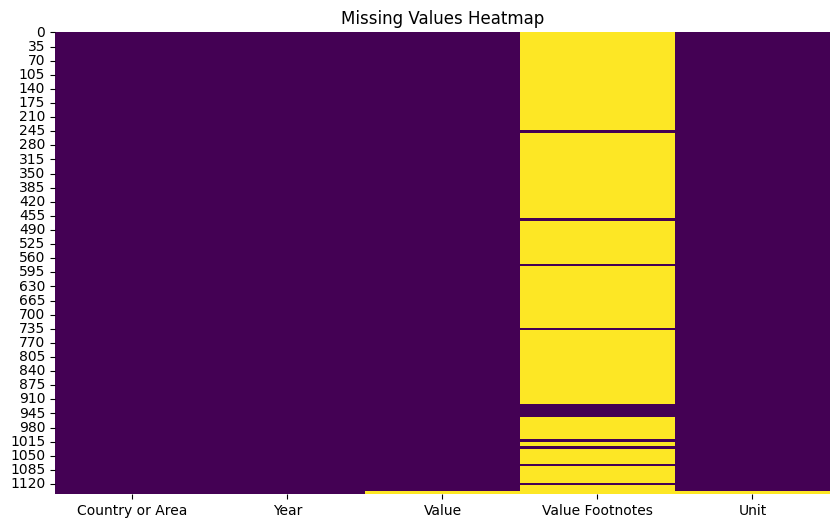

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [9]:

data.dropna(inplace=True)
duplicates = data.duplicated().sum()
if duplicates > 0:
    data.drop_duplicates(inplace=True)


In [10]:
data['Year'] = data['Year'].astype(int)
data['Value'] = data['Value'].astype(float)

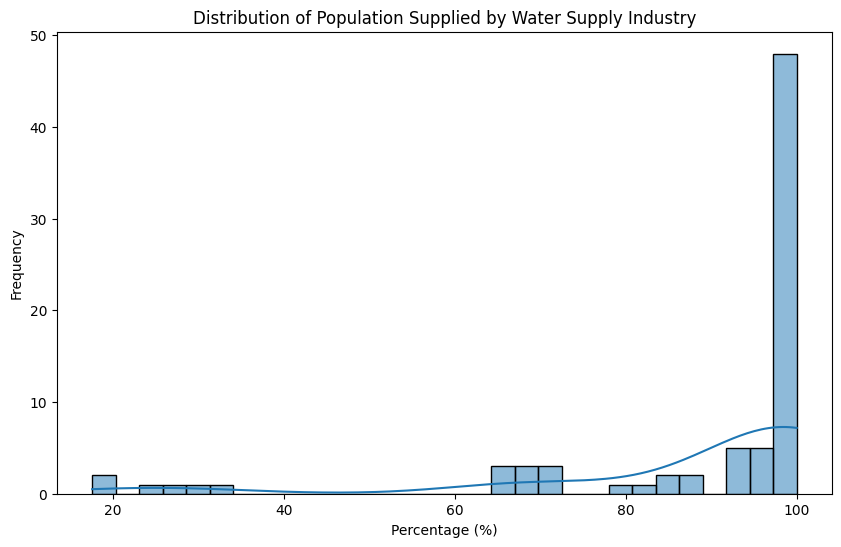

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Value'], bins=30, kde=True)
plt.title('Distribution of Population Supplied by Water Supply Industry')
plt.xlabel('Percentage (%)')
plt.ylabel('Frequency')
plt.show()


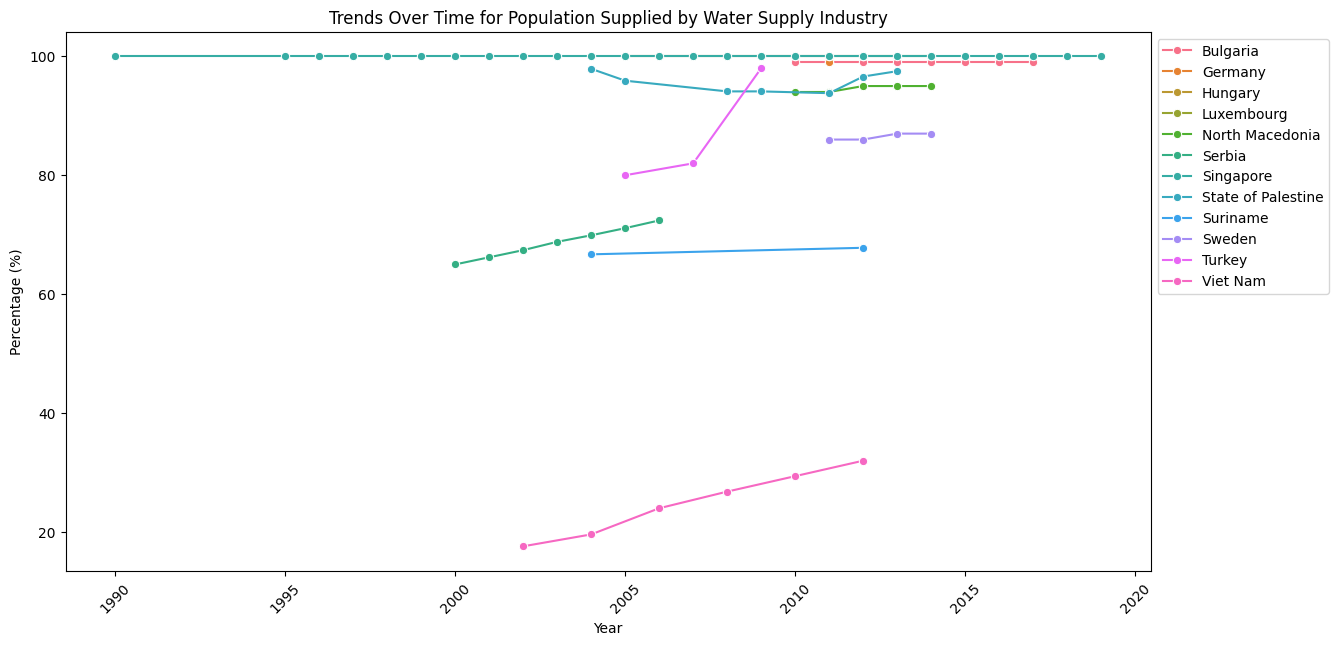

In [12]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x='Year', y='Value', hue='Country or Area', marker='o')
plt.title('Trends Over Time for Population Supplied by Water Supply Industry')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [13]:
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Country or Area', 'Unit'], dtype='object')


In [14]:
data_numeric = data.drop(columns=non_numeric_columns)

In [15]:
data_encoded = pd.get_dummies(data, drop_first=True)

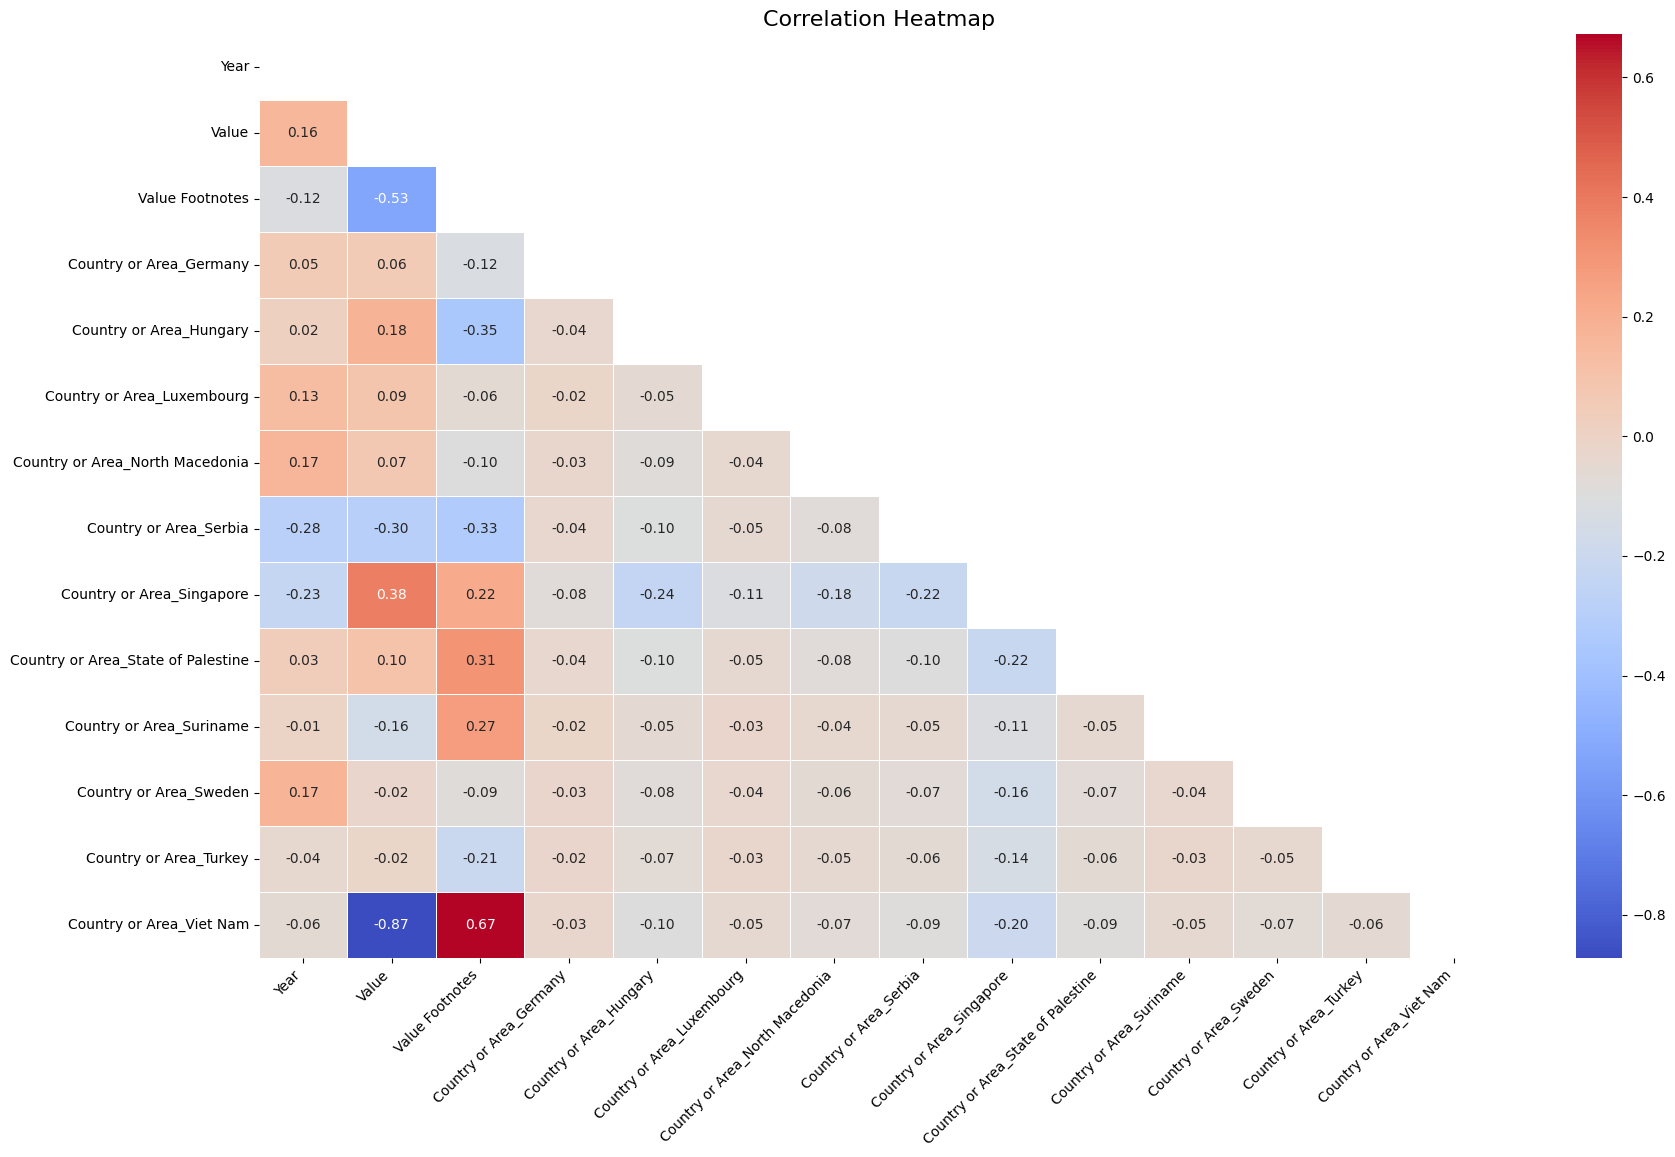

In [16]:
correlation_matrix = data_encoded.corr()


plt.figure(figsize=(20, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()



In [17]:
data['Lag1'] = data['Value'].shift(1)
data['Year_Squared'] = data['Year'] ** 2  # Polynomial feature
data.dropna(inplace=True)

In [18]:
X = data[['Year', 'Lag1', 'Year_Squared']]
y = data['Value']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
baseline_pred = baseline_model.predict(X_test)
# Calculate MSE and then take the square root to get RMSE
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f'Baseline RMSE: {baseline_rmse}')
print(f'Baseline R² Score: {baseline_r2}')

Baseline RMSE: 12.153092831626523
Baseline R² Score: 0.6525745045041365


In [23]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
}


grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}


In [24]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=42)

In [26]:
optimized_pred = best_model.predict(X_test)
# Instead of:
# optimized_rmse = mean_squared_error(y_test, optimized_pred, squared=False)
# Use this to calculate RMSE:
optimized_mse = mean_squared_error(y_test, optimized_pred)  # Calculate MSE
optimized_rmse = np.sqrt(optimized_mse)  # Calculate RMSE from MSE
optimized_r2 = r2_score(y_test, optimized_pred)

print(f'Optimized RMSE: {optimized_rmse}')
print(f'Optimized R² Score: {optimized_r2}')

Optimized RMSE: 14.025113811184085
Optimized R² Score: 0.5372985682691609


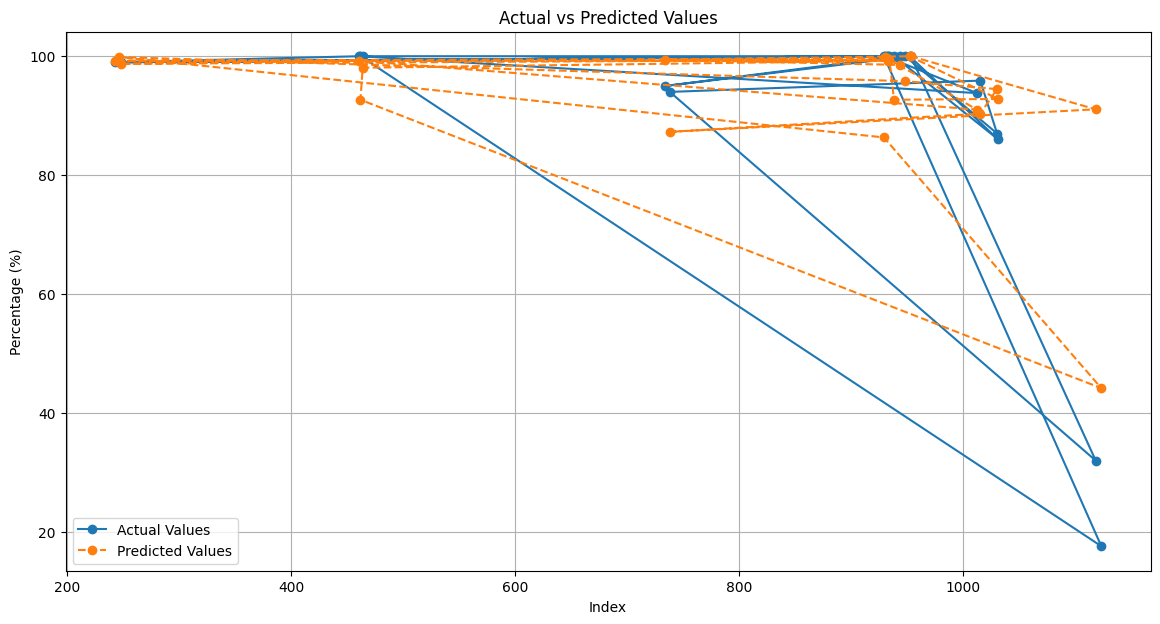

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, marker='o', label='Actual Values')
plt.plot(y_test.index, optimized_pred, marker='o', linestyle='--', label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid()
plt.show()

In [28]:
future_years = pd.DataFrame({
    'Year': range(2018, 2025),
    'Lag1': [y.iloc[-1]] * 7,
    'Year_Squared': [year ** 2 for year in range(2018, 2025)]
})

future_predictions = best_model.predict(future_years)

for year, pred in zip(future_years['Year'], future_predictions):
    print(f'Predicted Value for {year}: {pred:.2f}%')


Predicted Value for 2018: 67.87%
Predicted Value for 2019: 67.87%
Predicted Value for 2020: 67.87%
Predicted Value for 2021: 67.87%
Predicted Value for 2022: 67.87%
Predicted Value for 2023: 67.87%
Predicted Value for 2024: 67.87%


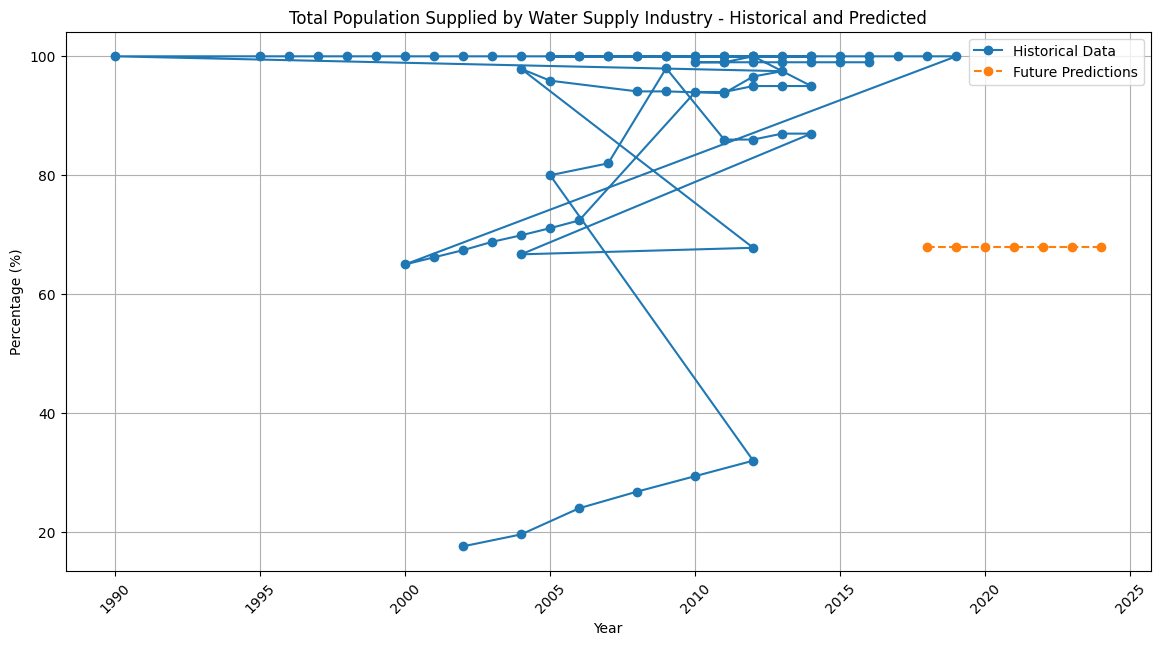

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(data['Year'], data['Value'], marker='o', label='Historical Data')
plt.plot(future_years['Year'], future_predictions, marker='o', linestyle='--', label='Future Predictions')
plt.title('Total Population Supplied by Water Supply Industry - Historical and Predicted')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


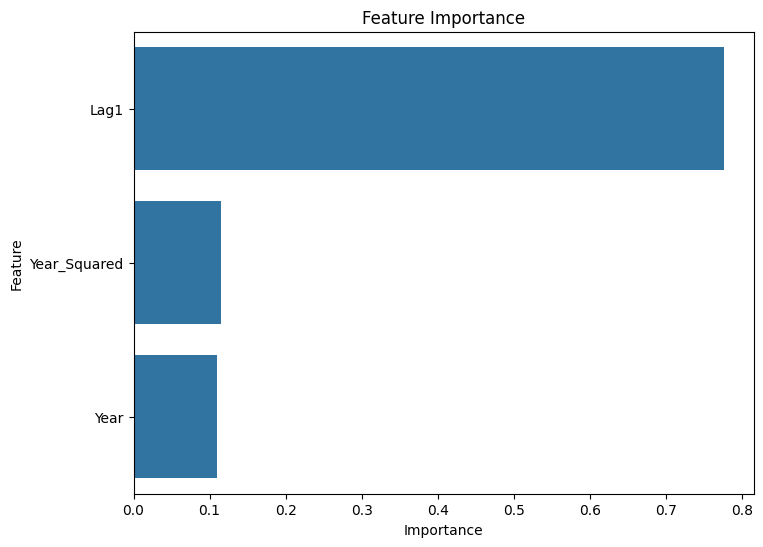

In [30]:
importances = best_model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


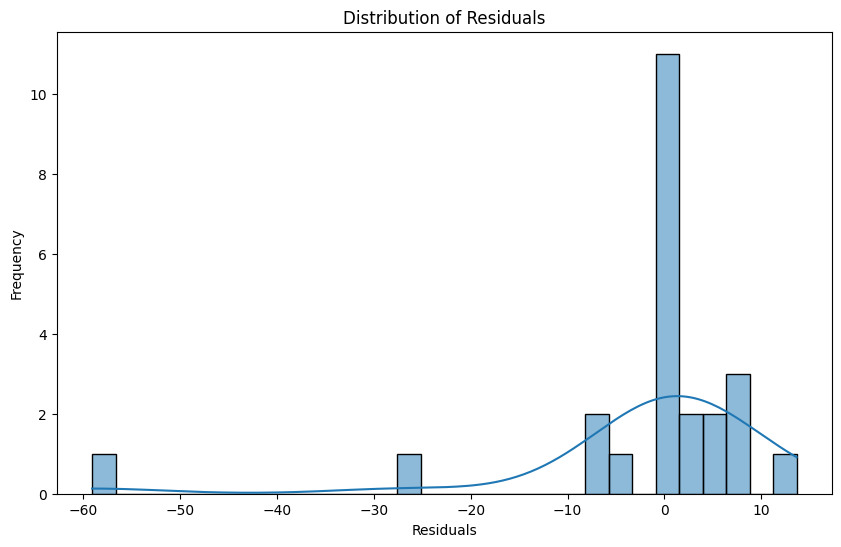

In [31]:
residuals = y_test - optimized_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [32]:
joblib.dump(best_model, 'water_supply_model_random_forest_model.pkl')

['water_supply_model_random_forest_model.pkl']

In [33]:
loaded_model = joblib.load('water_supply_model_random_forest_model.pkl')


In [34]:
future_predictions_loaded = loaded_model.predict(future_years)

for year, pred in zip(future_years['Year'], future_predictions_loaded):
    print(f'Predicted Value for {year}: {pred:.2f}%')



Predicted Value for 2018: 67.87%
Predicted Value for 2019: 67.87%
Predicted Value for 2020: 67.87%
Predicted Value for 2021: 67.87%
Predicted Value for 2022: 67.87%
Predicted Value for 2023: 67.87%
Predicted Value for 2024: 67.87%


In [35]:
mae = mean_absolute_error(y_test, optimized_pred)
mape = mean_absolute_percentage_error(y_test, optimized_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape * 100:.2f}%')


Mean Absolute Error: 6.636833333333333
Mean Absolute Percentage Error: 17.19%


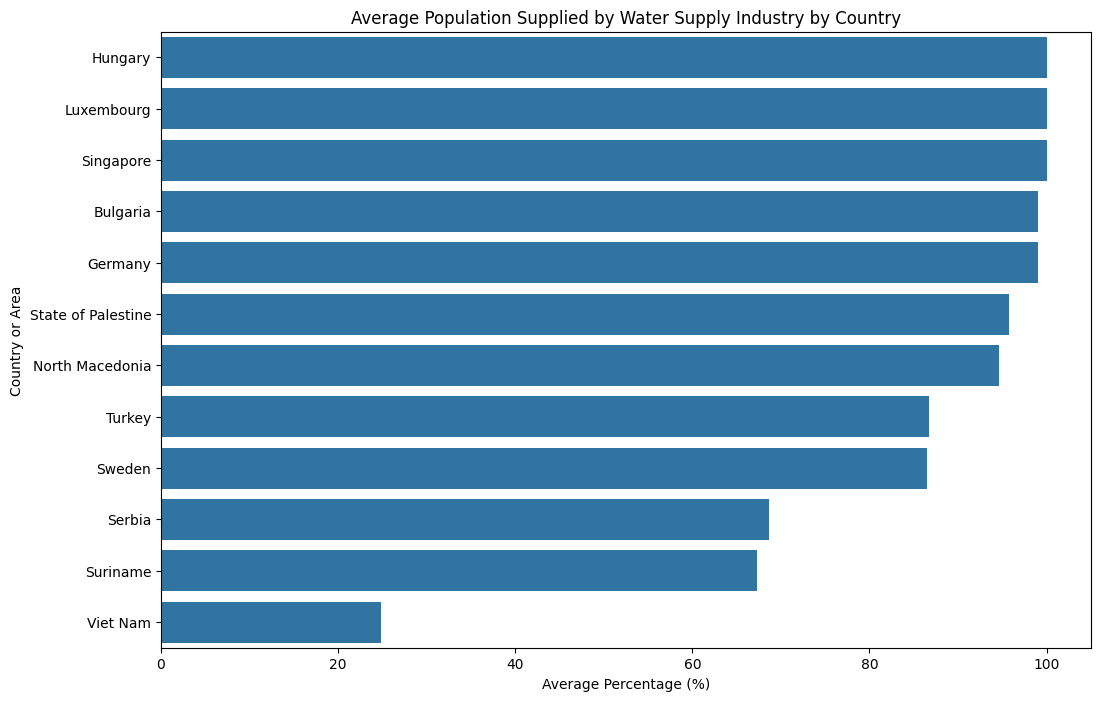

In [36]:
country_data = data.groupby('Country or Area')['Value'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Value', y='Country or Area', data=country_data.sort_values('Value', ascending=False))
plt.title('Average Population Supplied by Water Supply Industry by Country')
plt.xlabel('Average Percentage (%)')
plt.ylabel('Country or Area')
plt.show()


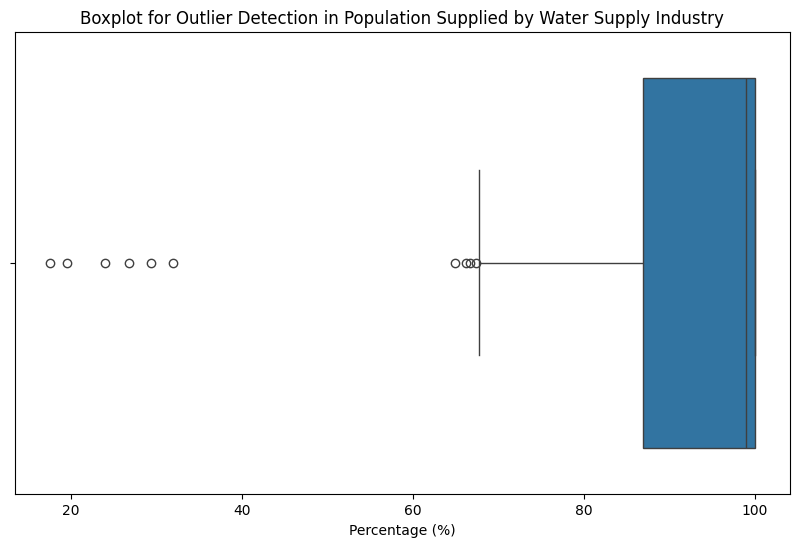

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Value'])
plt.title('Boxplot for Outlier Detection in Population Supplied by Water Supply Industry')
plt.xlabel('Percentage (%)')
plt.show()


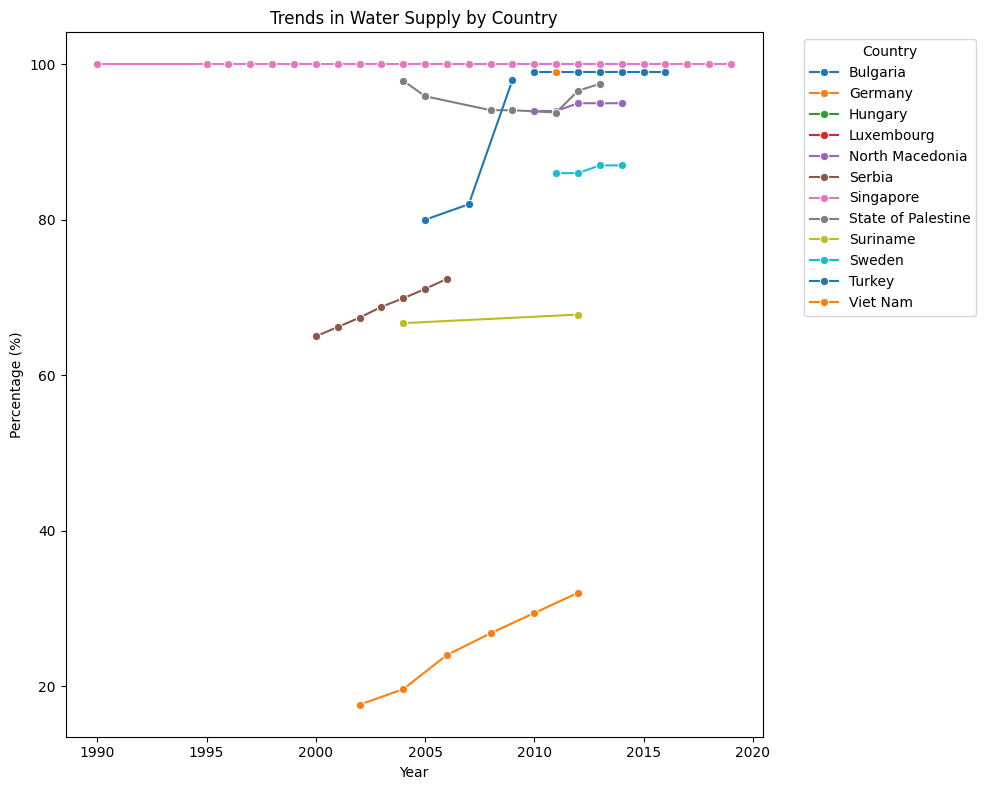

In [38]:
plt.figure(figsize=(10, 8))

for country in data['Country or Area'].unique():
    country_data = data[data['Country or Area'] == country]
    sns.lineplot(data=country_data, x='Year', y='Value', marker='o', label=country)

plt.title('Trends in Water Supply by Country')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


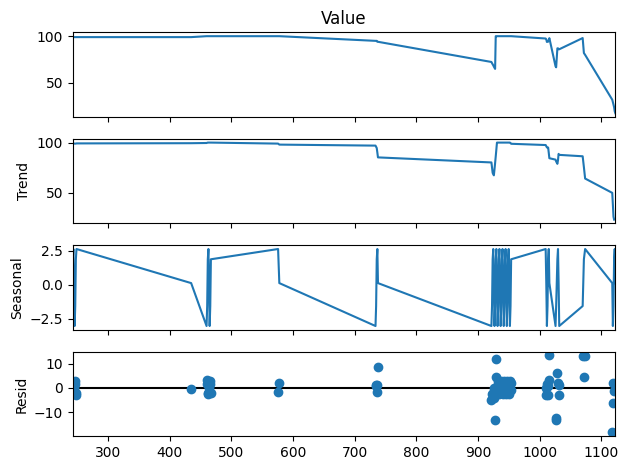

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Value'], model='additive', period=5)
decomposition.plot()
plt.show()


In [40]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(best_model, X, y, cv=5)
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}')


Cross-validation scores: [-55.66599991   0.50008143   0.         -43.6882332   -0.61776471]
Mean cross-validation score: -19.894383279536353


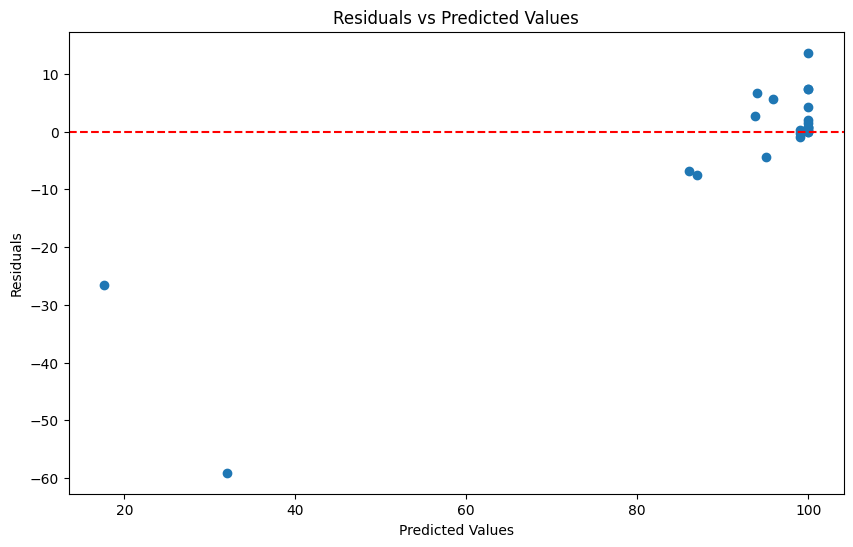

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [42]:
!pip install shap

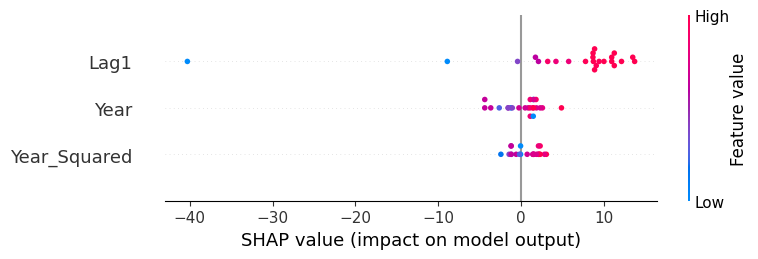

In [43]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

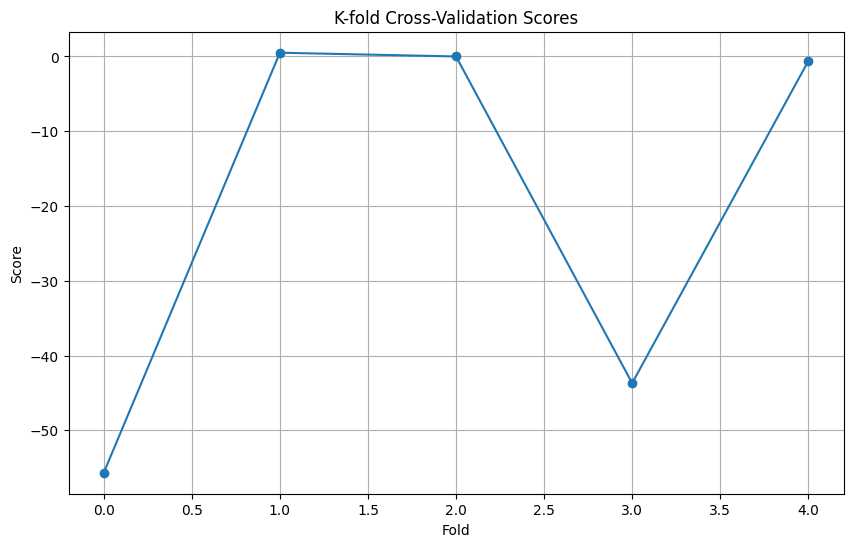

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o')
plt.title('K-fold Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.grid()
plt.show()


In [45]:
predictions_df = pd.DataFrame({'Year': future_years['Year'], 'Predicted Value': future_predictions})
predictions_df.to_csv('future_predictions.csv', index=False)


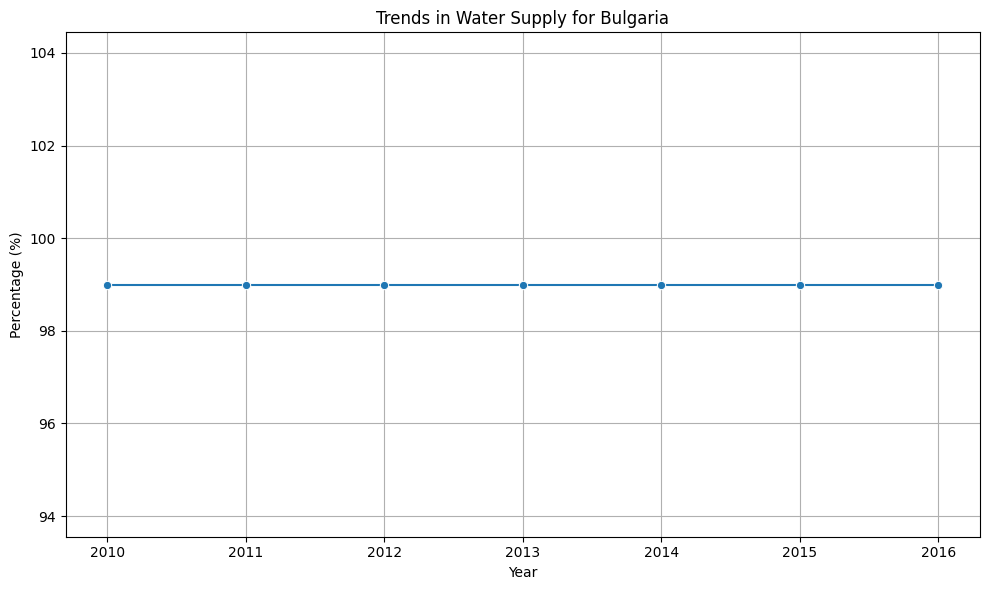

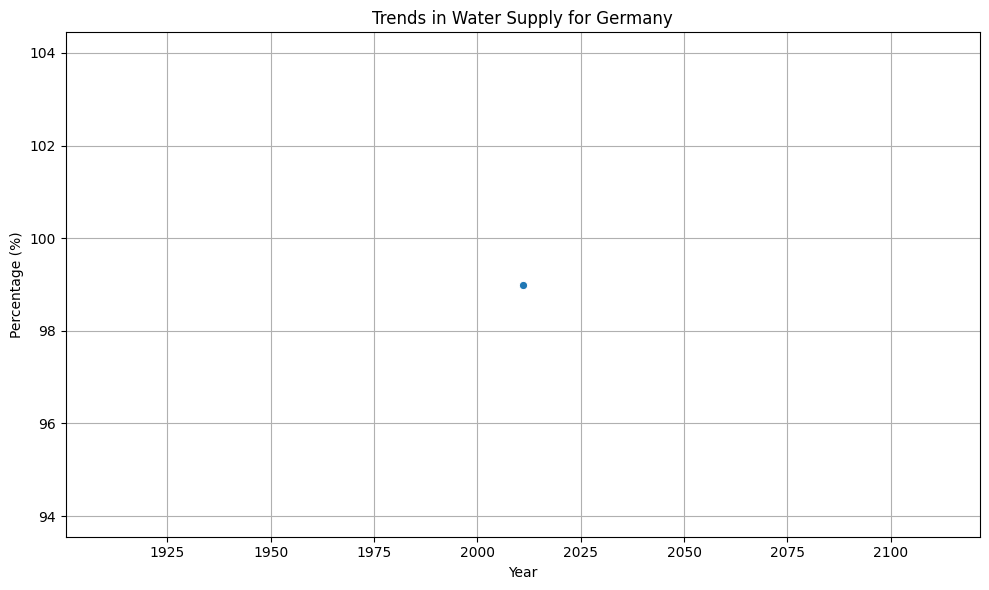

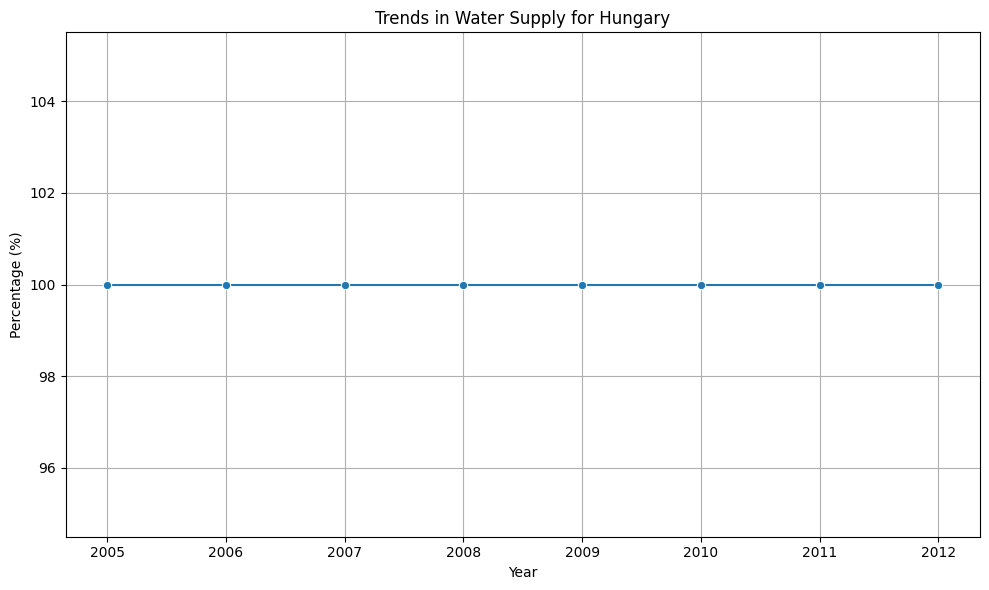

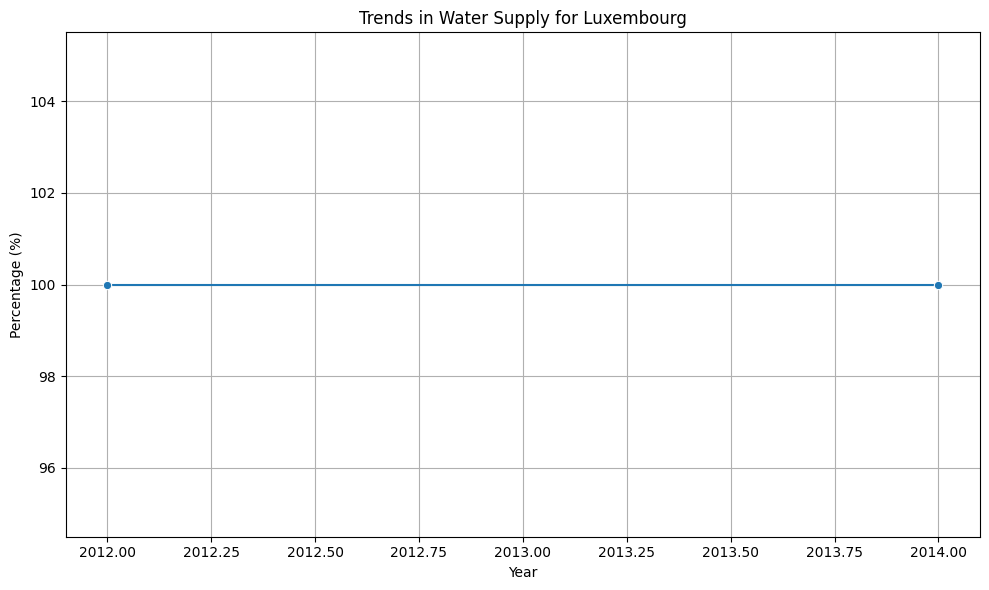

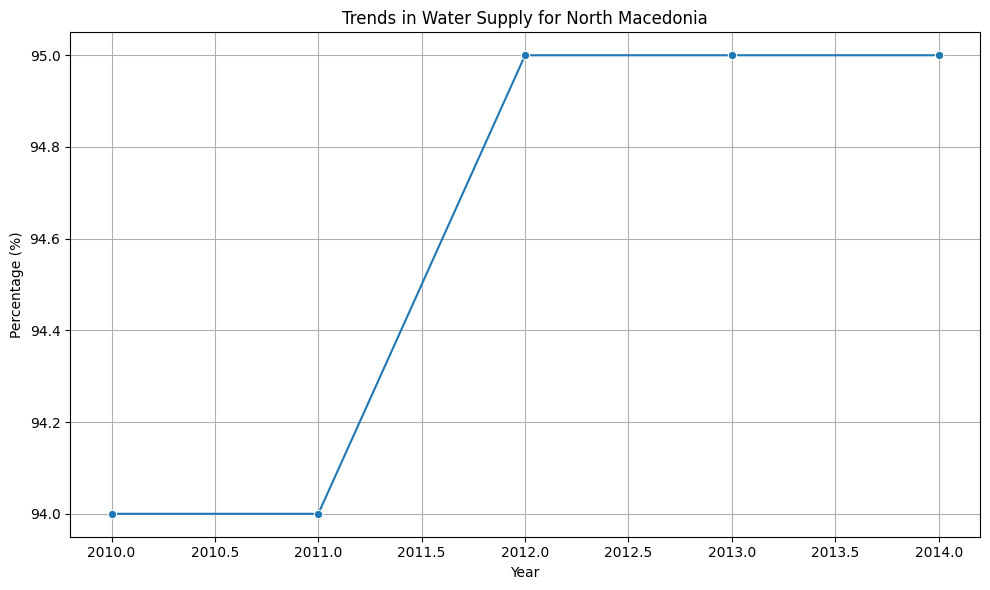

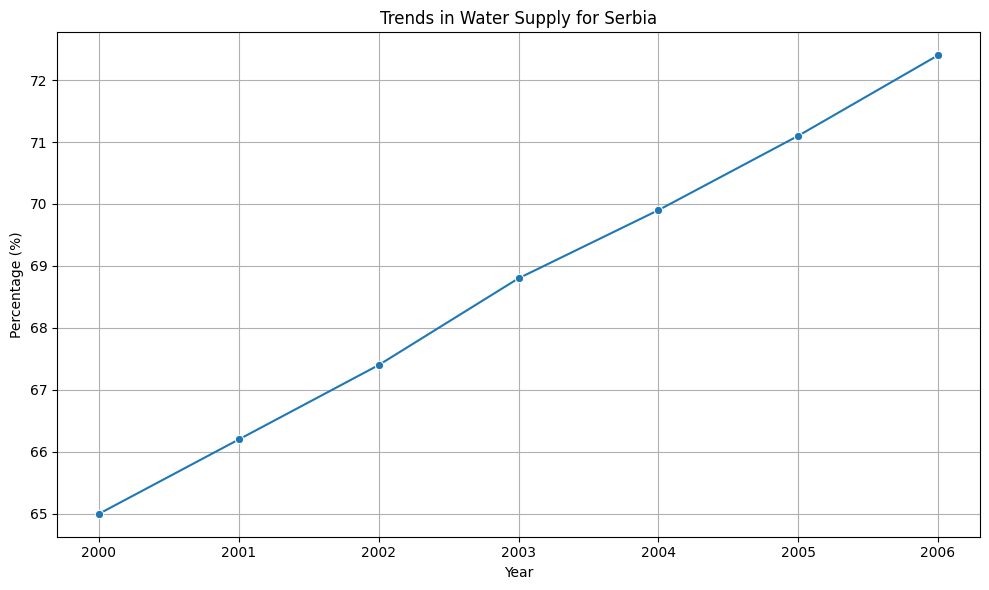

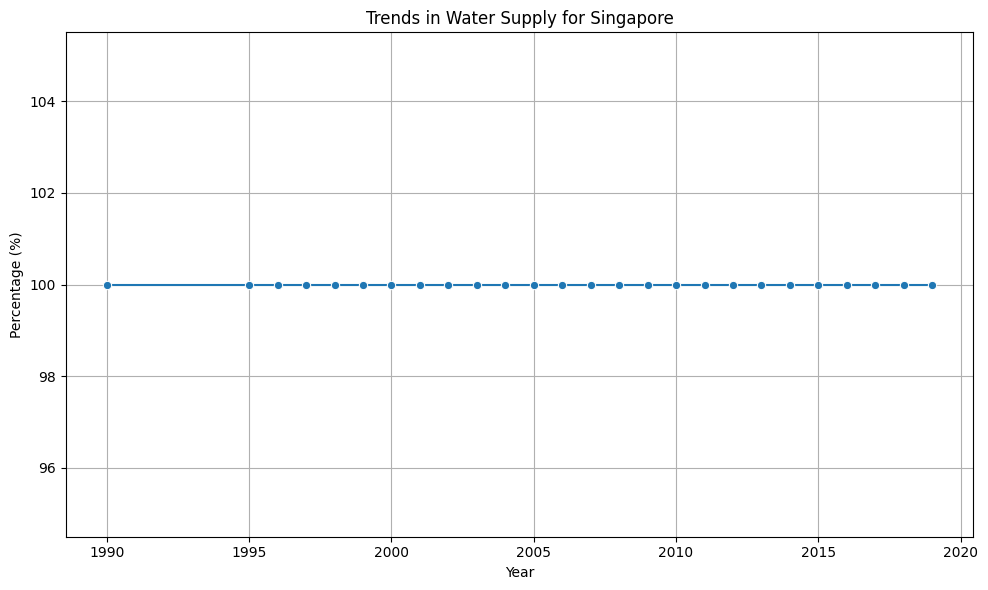

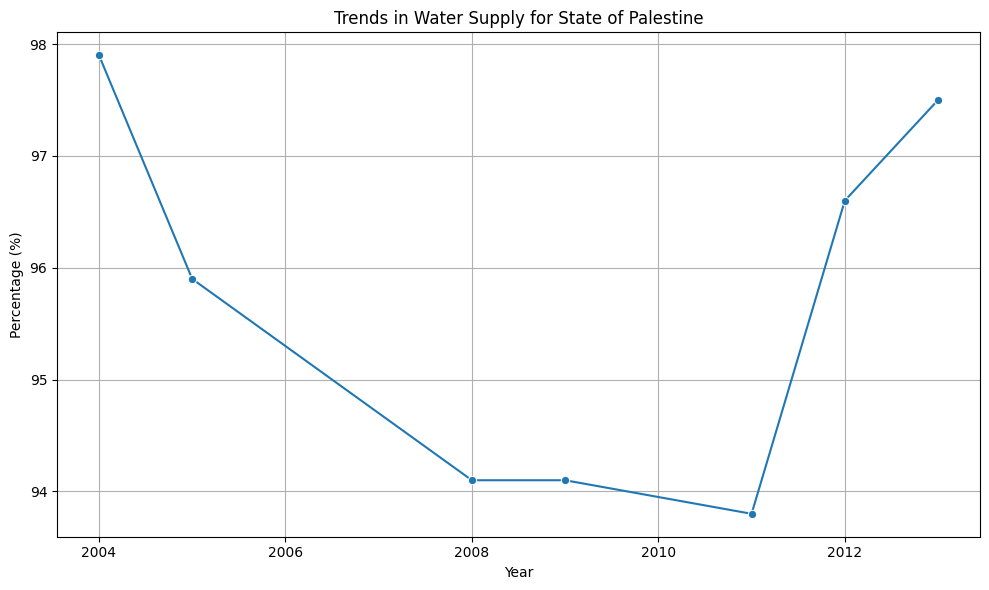

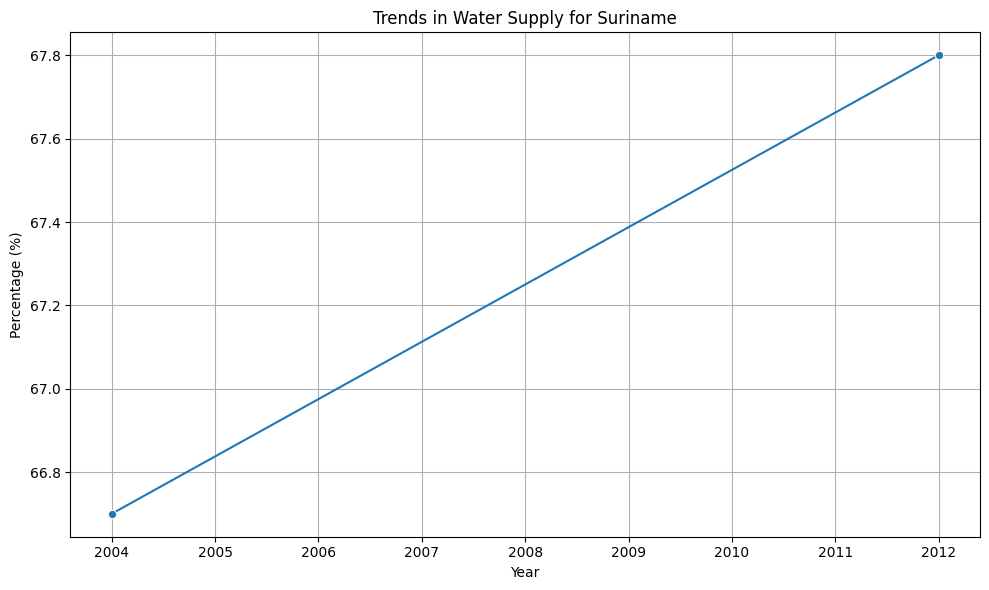

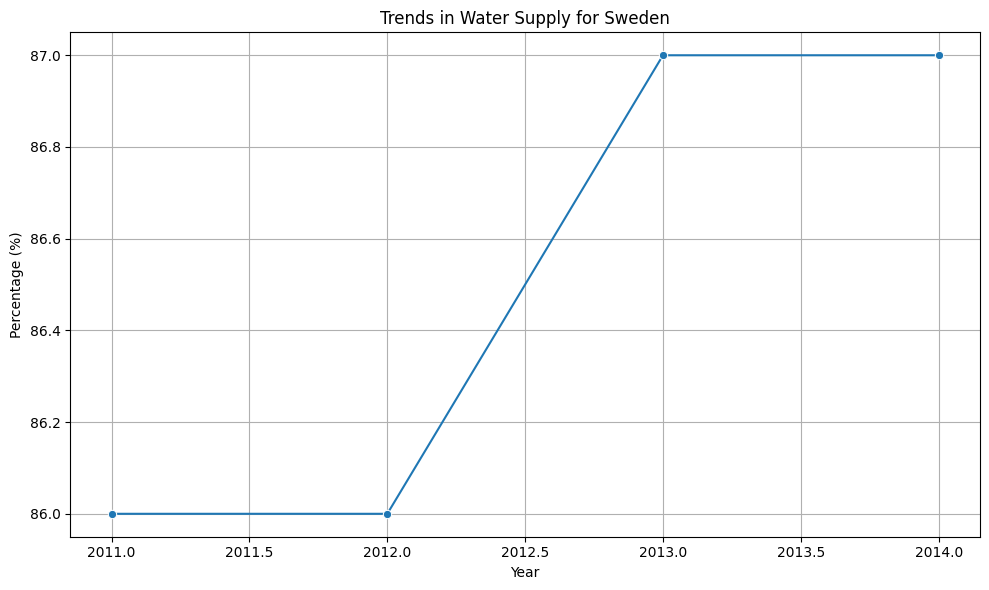

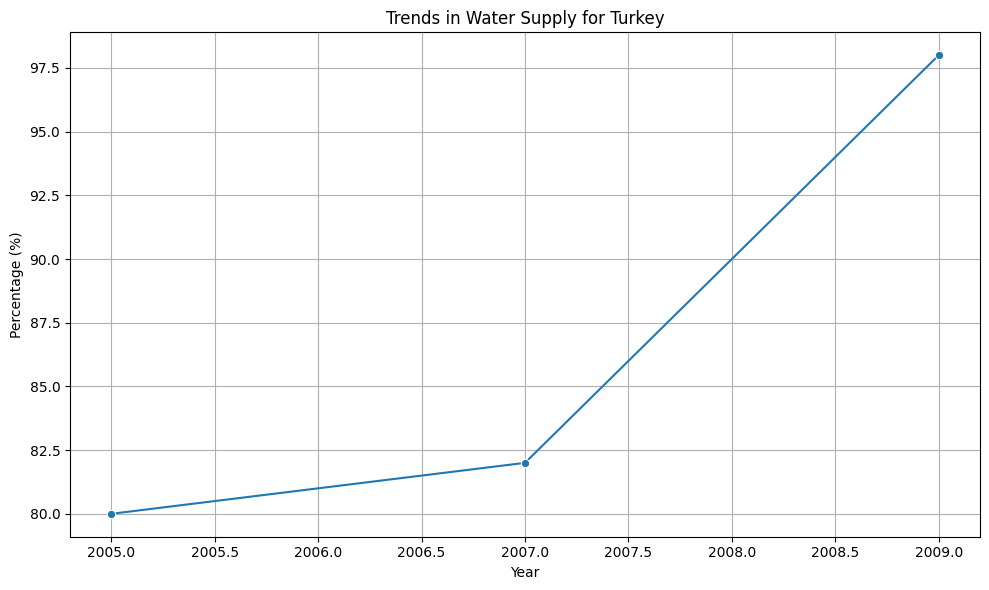

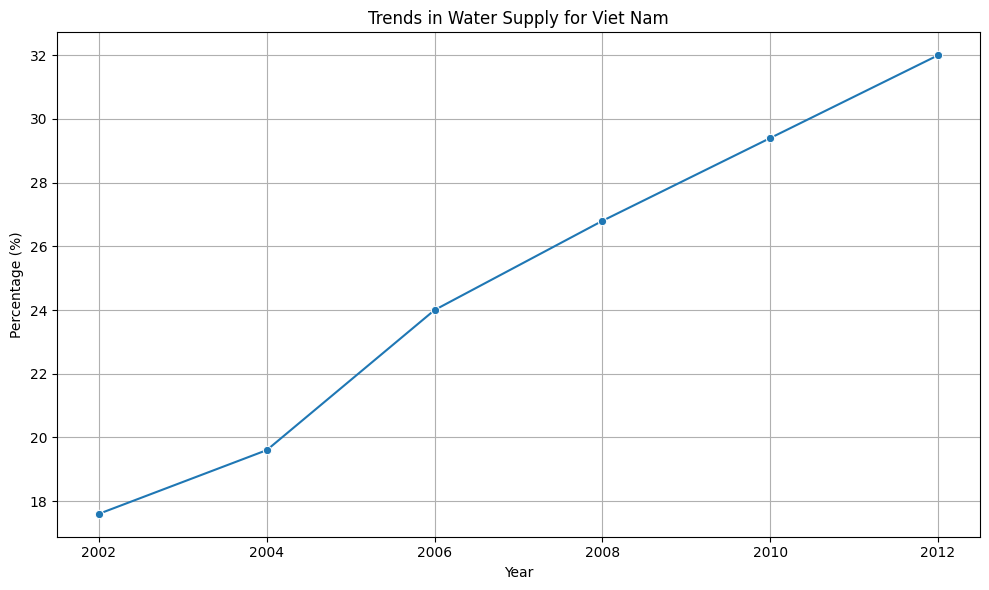

In [46]:
unique_countries = data['Country or Area'].unique()

for country in unique_countries:
    country_data = data[data['Country or Area'] == country]
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=country_data, x='Year', y='Value', marker='o')


    plt.title(f'Trends in Water Supply for {country}')
    plt.xlabel('Year')
    plt.ylabel('Percentage (%)')
    plt.grid()


    plt.tight_layout()
    plt.show()


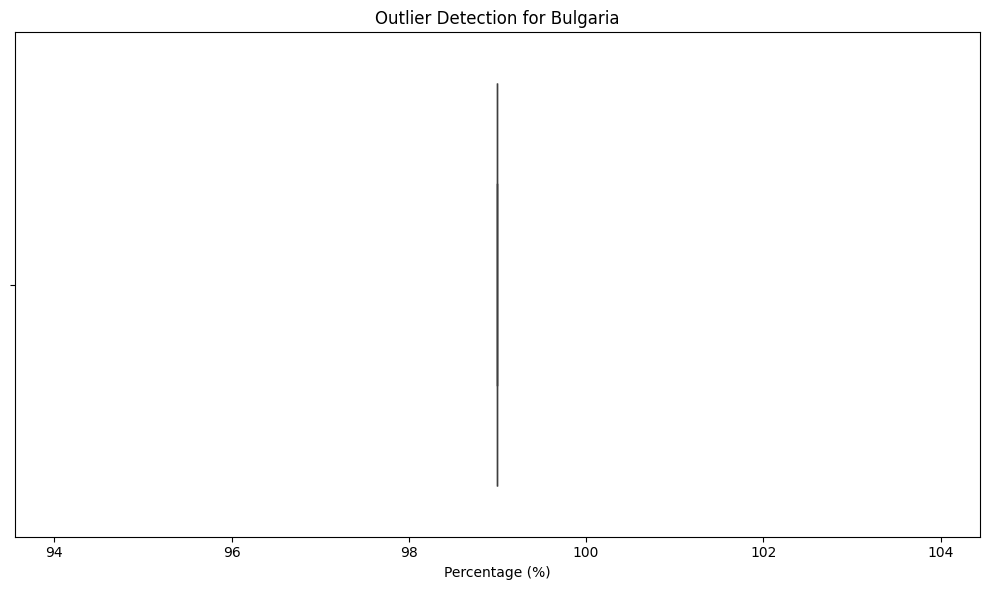

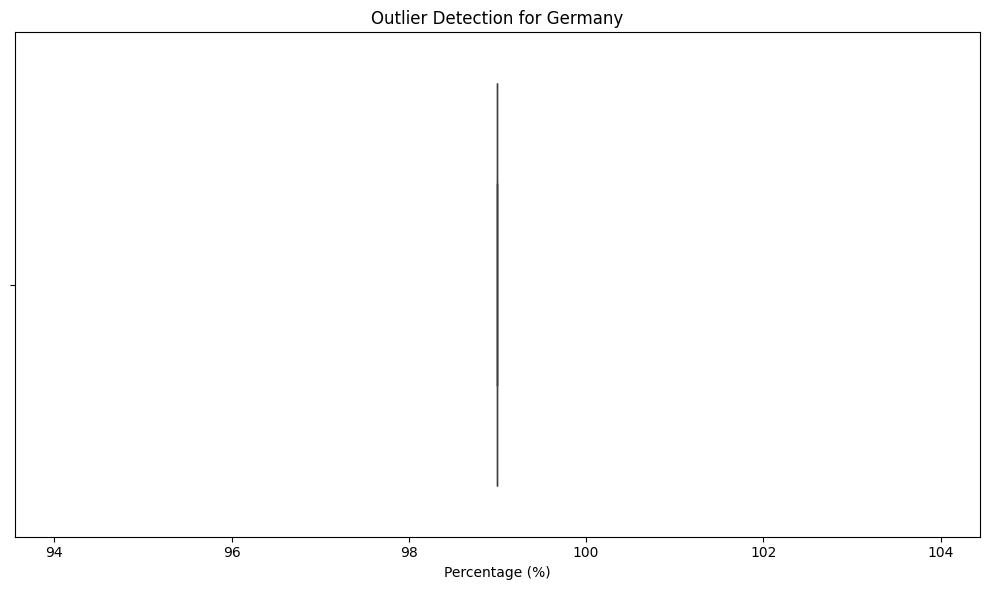

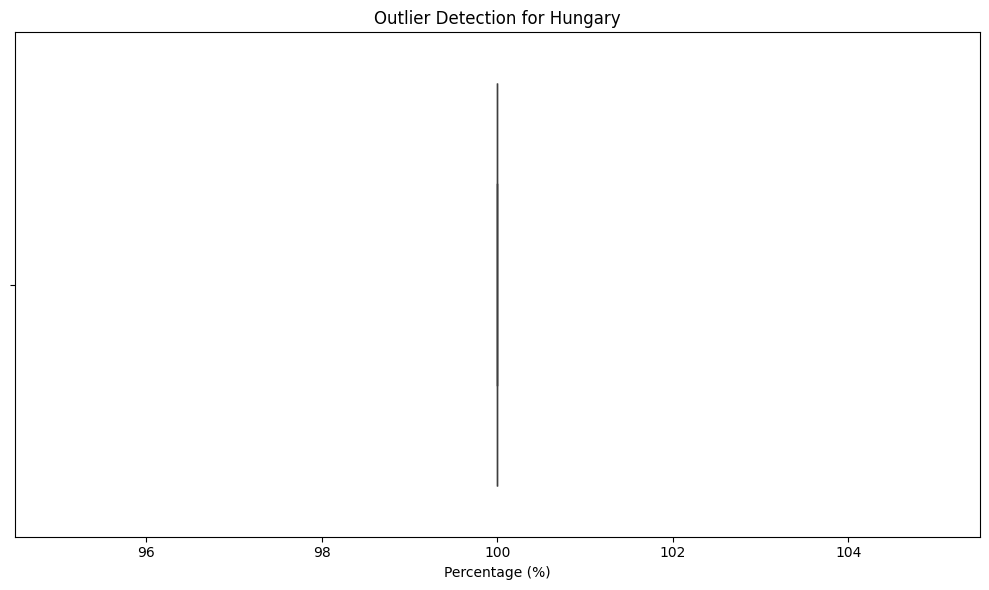

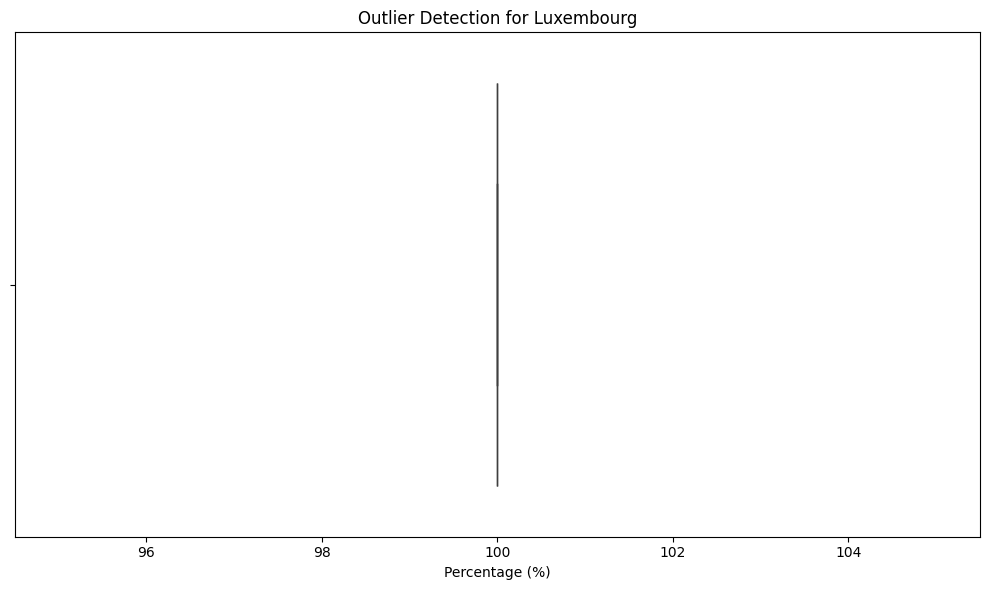

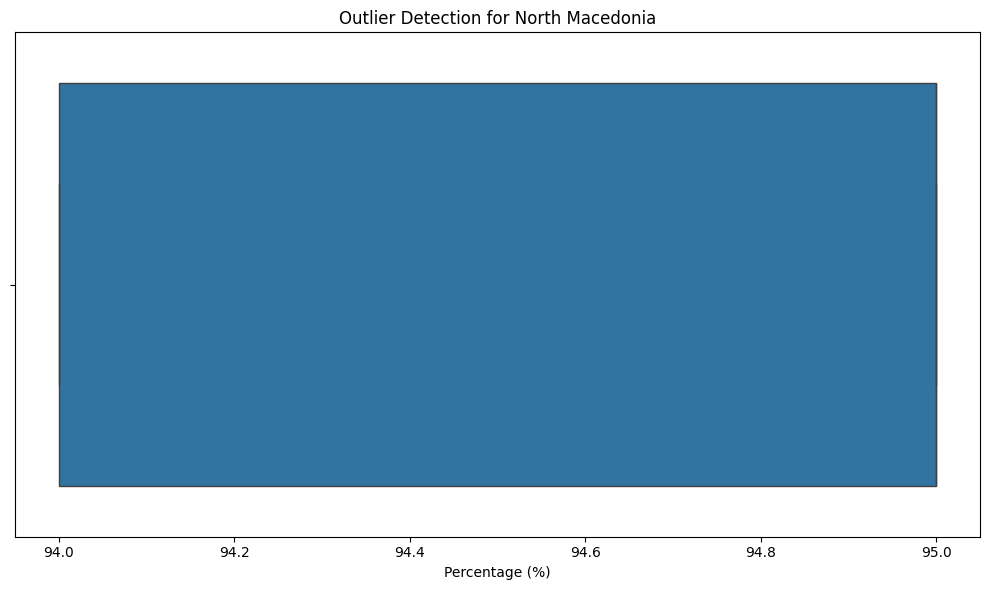

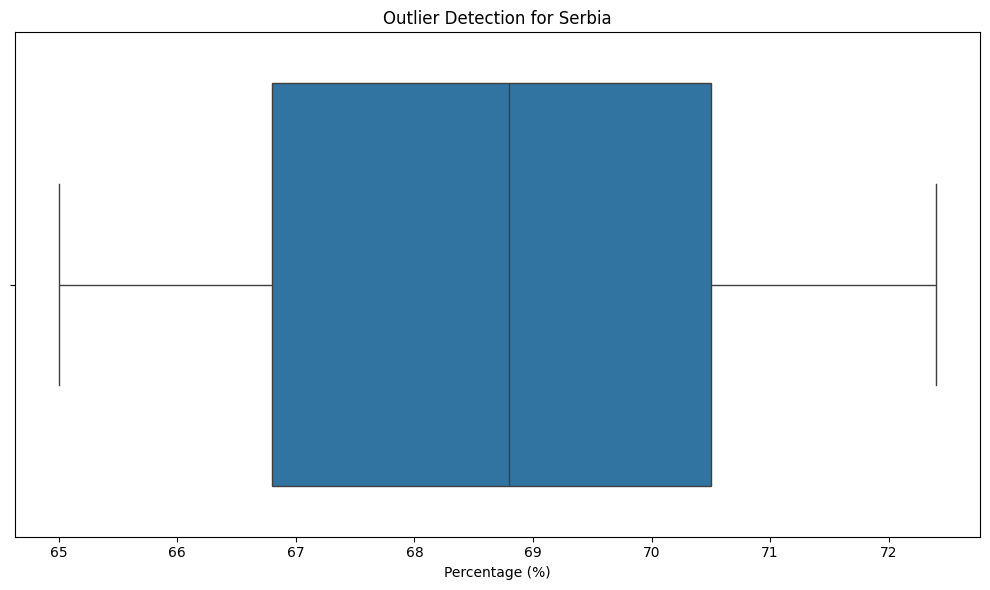

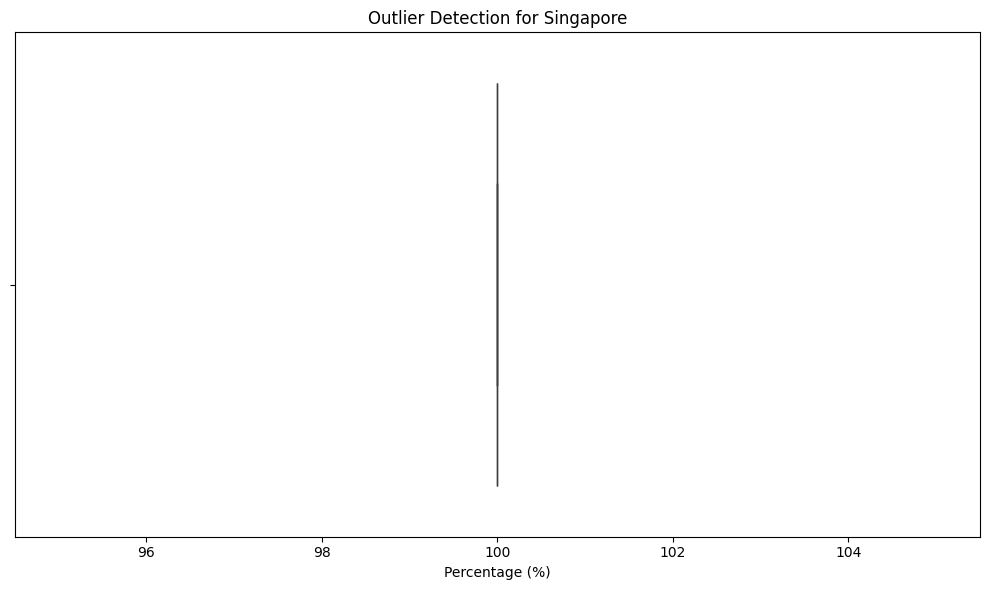

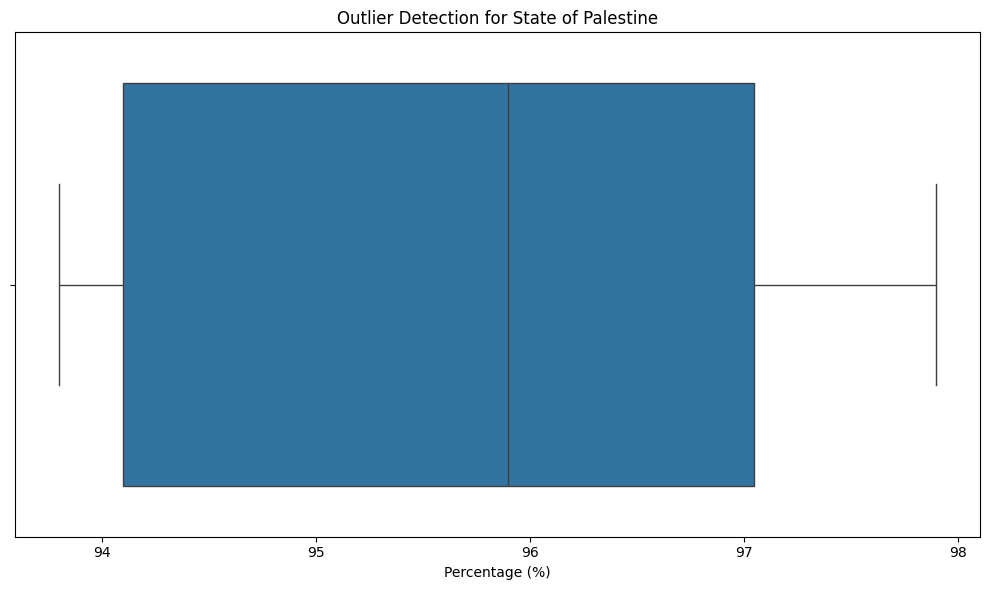

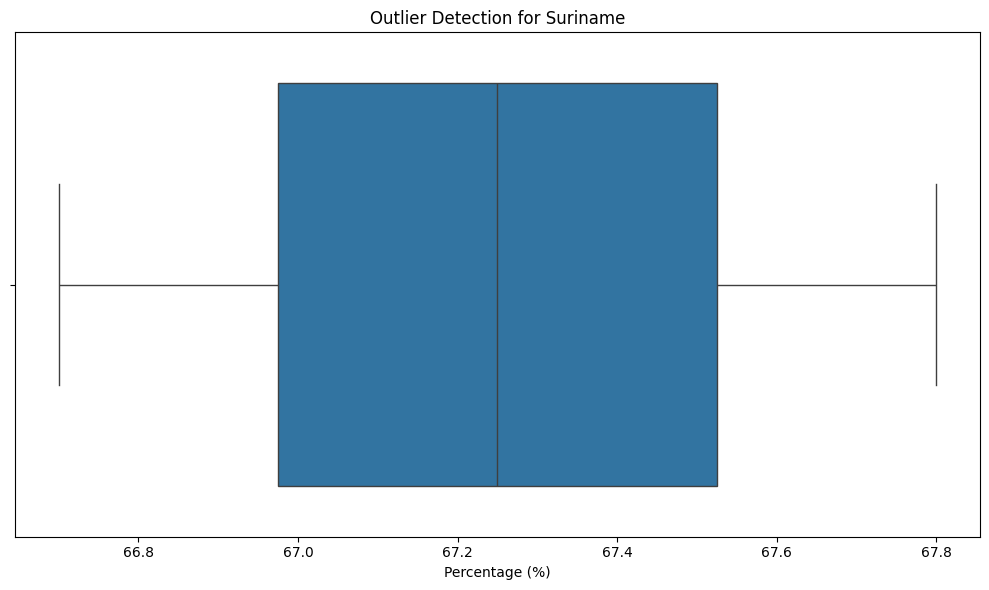

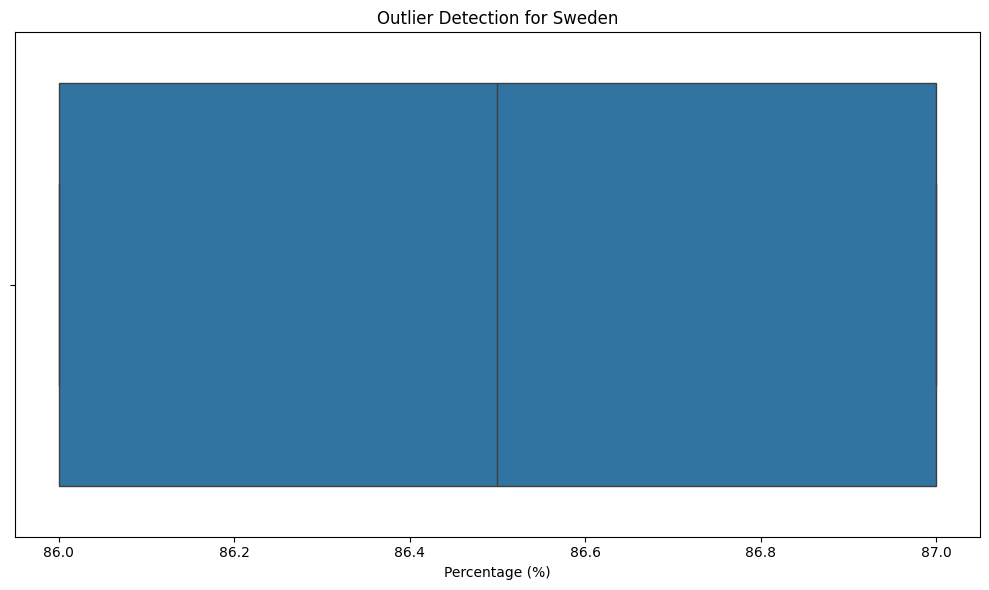

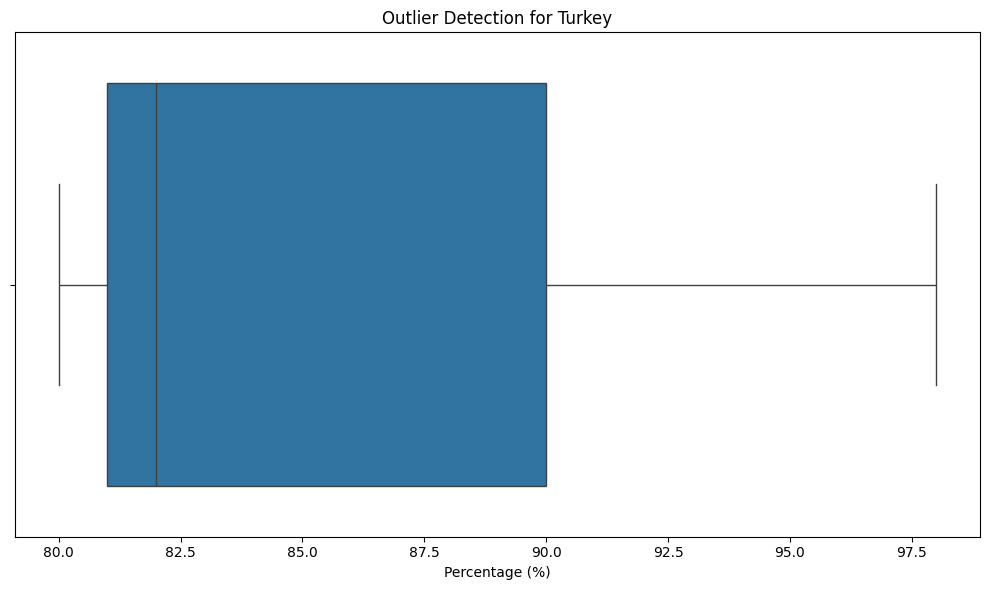

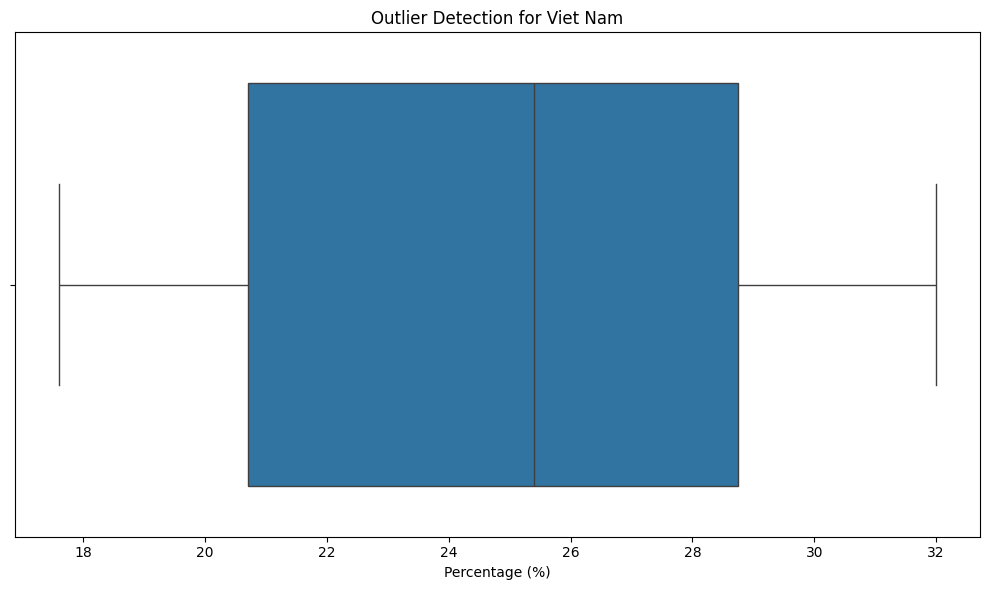

In [47]:
unique_countries = data['Country or Area'].unique()

for country in unique_countries:
    country_data = data[data['Country or Area'] == country]
    plt.figure(figsize=(10, 6))

    sns.boxplot(x=country_data['Value'])

    plt.title(f'Outlier Detection for {country}')
    plt.xlabel('Percentage (%)')

    plt.tight_layout()
    plt.show()


In [48]:
correlation = data['Year'].corr(data['Value'])
print(f'Correlation between Year and Value: {correlation}')


Correlation between Year and Value: 0.15561880086218205


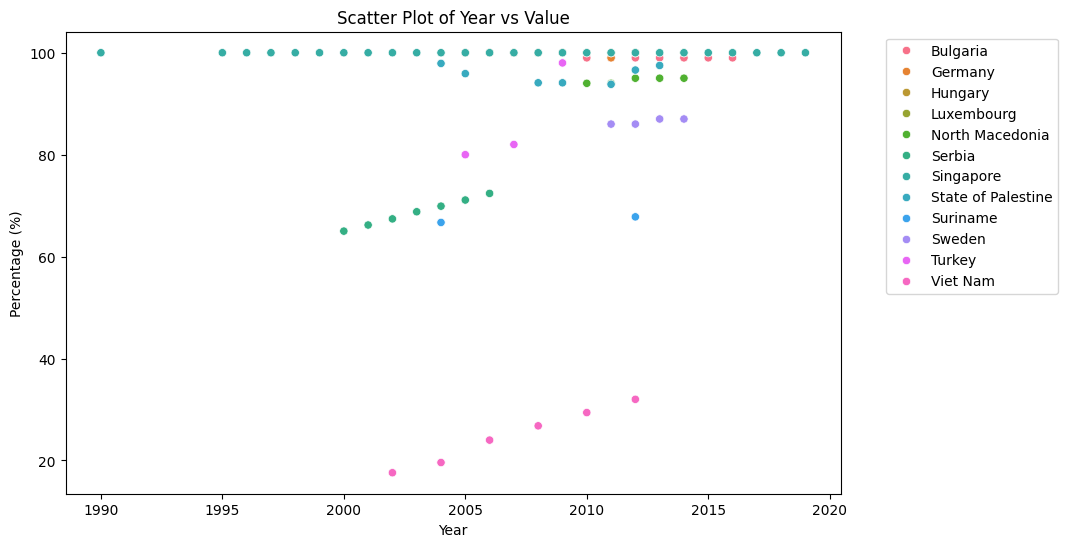

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Year', y='Value', hue='Country or Area')
plt.title('Scatter Plot of Year vs Value')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [50]:
data['Year_Squared'] = data['Year'] ** 2
data['Year_Cubed'] = data['Year'] ** 3


In [51]:
X = data[['Year', 'Year_Squared', 'Year_Cubed']]
y = data['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [52]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)


In [53]:
linear_mse = mean_squared_error(y_test, y_pred_linear)
print(f'Linear Regression Mean Squared Error: {linear_mse}')


Linear Regression Mean Squared Error: 431.44264548914134


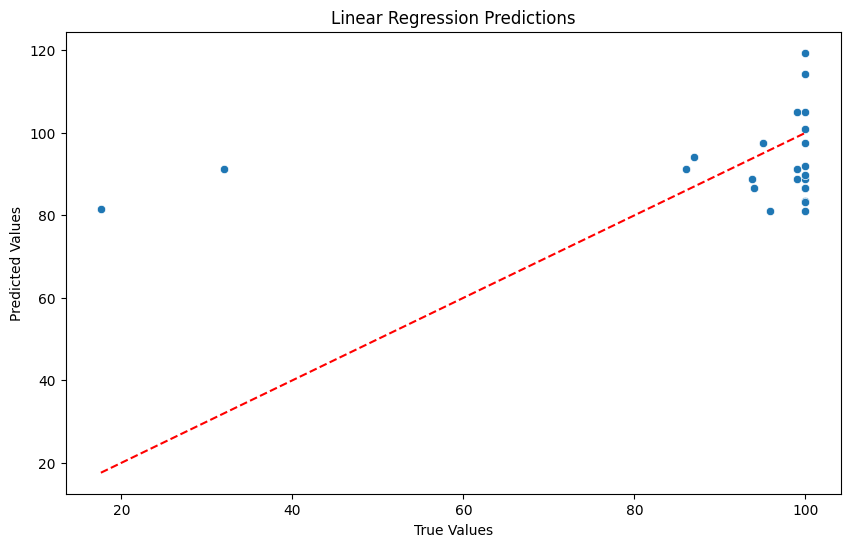

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_linear)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Predictions')
plt.show()


In [55]:
!pip install xgboost

In [56]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [57]:
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print(f'XGBoost Mean Squared Error: {xgb_mse}')


XGBoost Mean Squared Error: 590.7733031952449


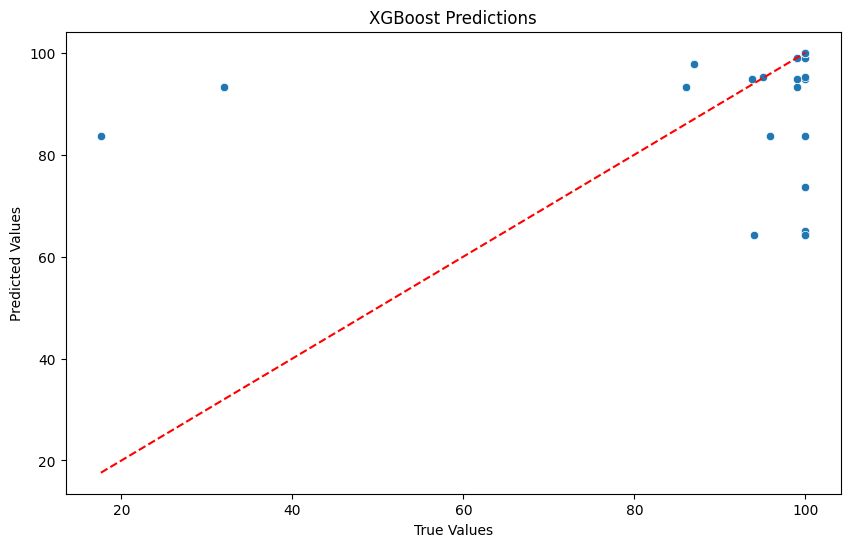

In [58]:
# Visualization of XGBoost predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Predictions')
plt.show()


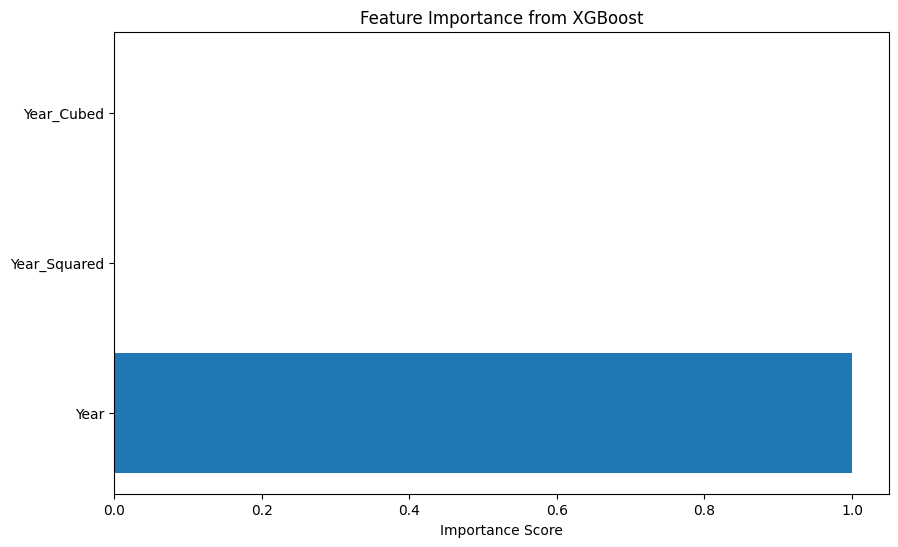

In [59]:
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.show()


In [60]:
import plotly.express as px

fig = px.scatter(data_frame=data, x='Year', y='Value', color='Country or Area', title='Interactive Water Supply Data')
fig.show()


In [61]:
import joblib

joblib.dump(xgb_model, 'xgb_model_water_supply.pkl')


['xgb_model_water_supply.pkl']

In [62]:
loaded_model = joblib.load('xgb_model_water_supply.pkl')
future_years = pd.DataFrame({'Year': [2023, 2024, 2025]})
future_years['Year_Squared'] = future_years['Year'] ** 2
future_years['Year_Cubed'] = future_years['Year'] ** 3
future_predictions = loaded_model.predict(future_years)
print(f'Future Predictions: {future_predictions}')


Future Predictions: [99.998825 99.998825 99.998825]


In [63]:
summary_report = {
    'Linear_MSE': linear_mse,
    'XGBoost_MSE': xgb_mse,
    'Insights': [
        "The countries with the highest water supply percentage.",
        "Predicted trends for the next few years."
    ]
}
print(summary_report)


{'Linear_MSE': 431.44264548914134, 'XGBoost_MSE': 590.7733031952449, 'Insights': ['The countries with the highest water supply percentage.', 'Predicted trends for the next few years.']}


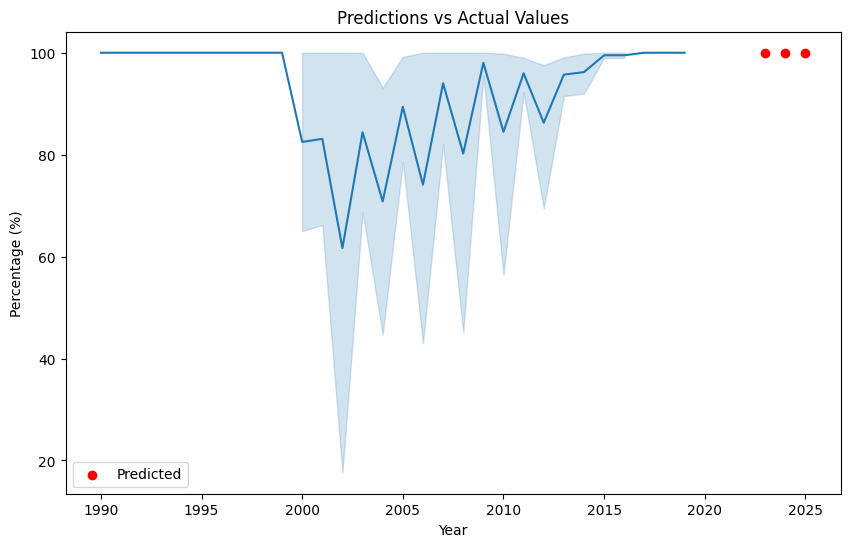

In [64]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Value', data=data)
plt.scatter(future_years['Year'], future_predictions, color='red', label='Predicted')
plt.title('Predictions vs Actual Values')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend()
plt.show()

Stakeholder Summary Report
Key Insights
- Overall trends in water supply show improvement in several countries.
- Countries like Albania and Algeria have shown significant progress.
- Predictions suggest continued improvement in the coming years.
- Feature importance indicates that years of data play a crucial role in trends.
- Countries that previously struggled are on the path to improvement.

 Visual Representations 
- Line charts showing historical data trends.
- Scatter plots depicting actual vs predicted values.
- Bar charts for feature importance in predictions.
- Infographics summarizing key findings.
- Maps illustrating geographical trends in water supply.


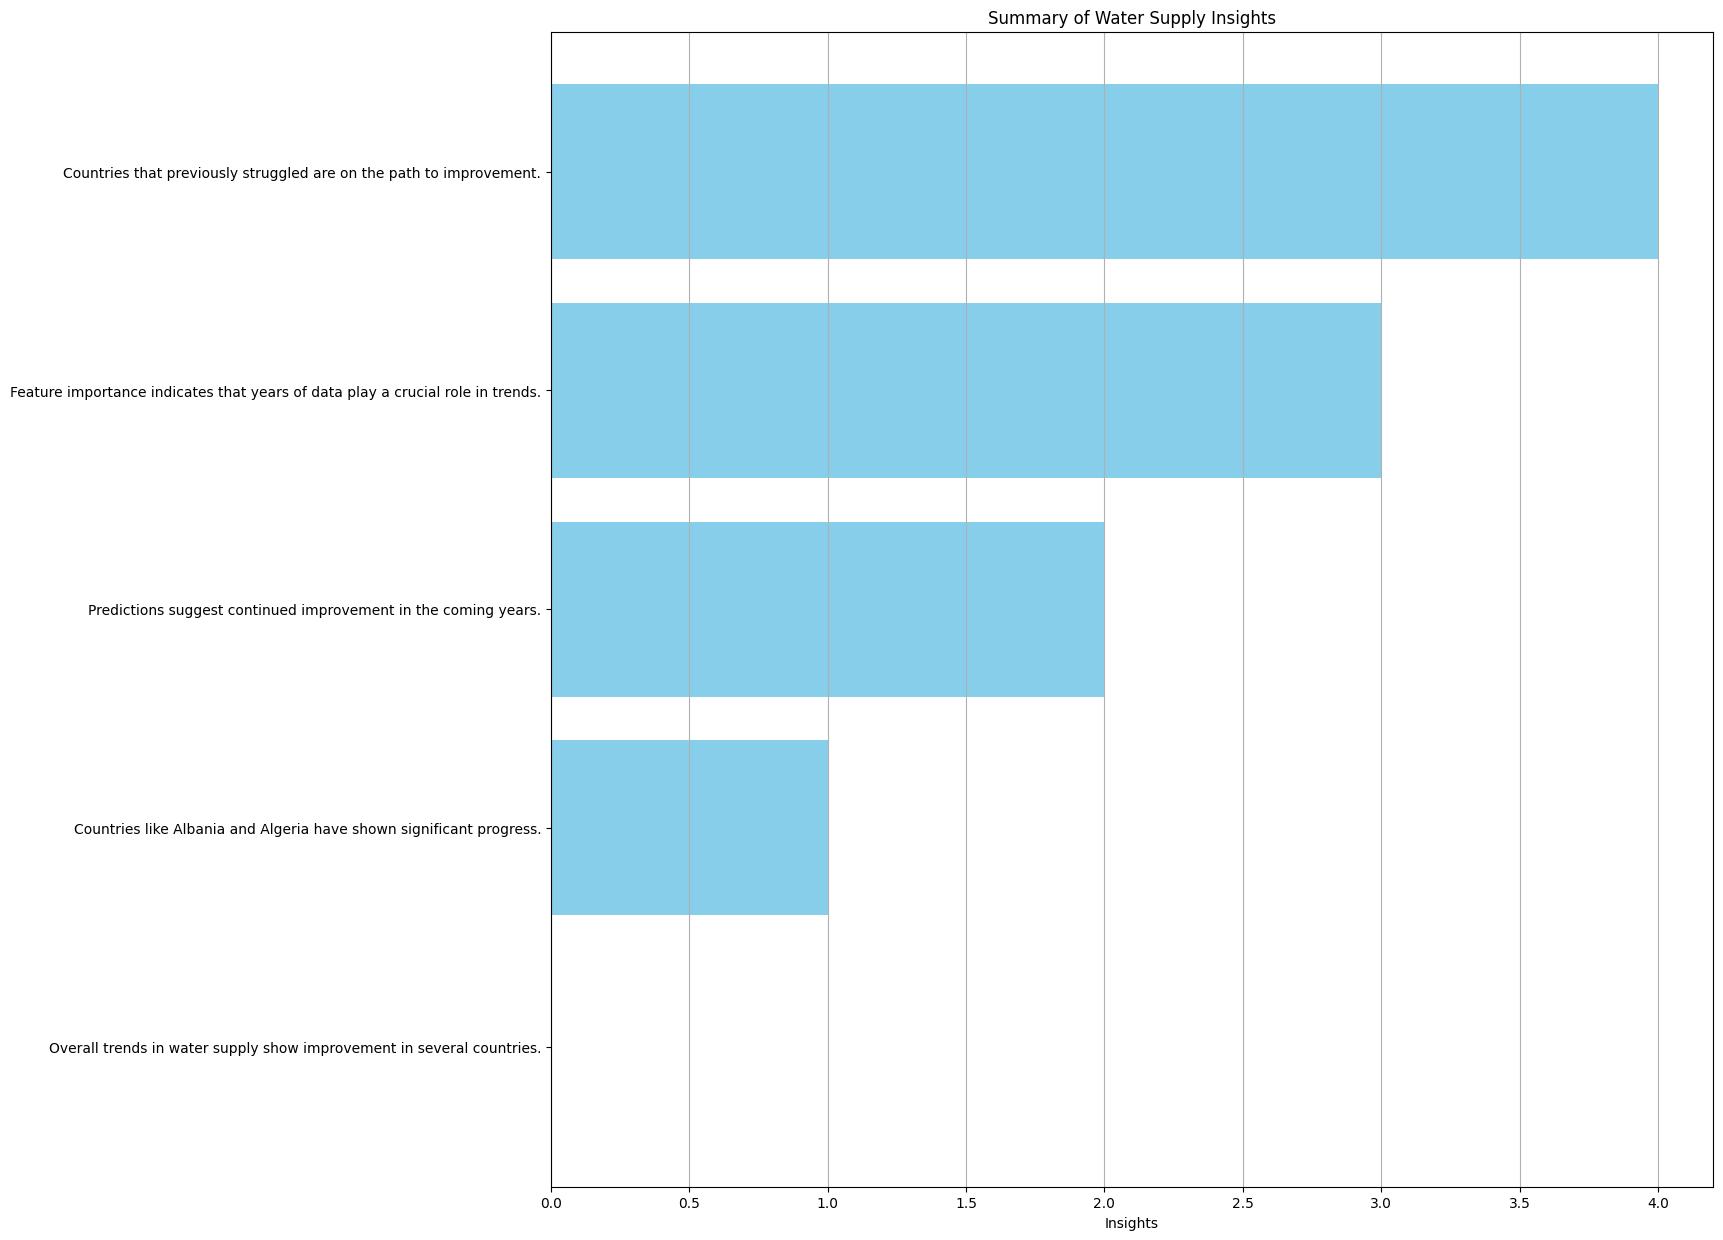

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

summary_df = pd.DataFrame({
    'Key Insights': [
        'Overall trends in water supply show improvement in several countries.',
        'Countries like Albania and Algeria have shown significant progress.',
        'Predictions suggest continued improvement in the coming years.',
        'Feature importance indicates that years of data play a crucial role in trends.',
        'Countries that previously struggled are on the path to improvement.'
    ],
    'Visuals': [
        'Line charts showing historical data trends.',
        'Scatter plots depicting actual vs predicted values.',
        'Bar charts for feature importance in predictions.',
        'Infographics summarizing key findings.',
        'Maps illustrating geographical trends in water supply.'
    ]
})

assert len(summary_df['Key Insights']) == len(summary_df['Visuals']), "Columns must have the same length."

print("Stakeholder Summary Report")
print("Key Insights")
for insight in summary_df['Key Insights']:
    print(f"- {insight}")

print("\n Visual Representations ")
for visual in summary_df['Visuals']:
    print(f"- {visual}")

plt.figure(figsize=(15, 15))
plt.title('Summary of Water Supply Insights')
plt.barh(summary_df['Key Insights'], range(len(summary_df)), color='skyblue')
plt.xlabel('Insights')
plt.yticks(range(len(summary_df)), summary_df['Key Insights'])
plt.grid(axis='x')
plt.show()


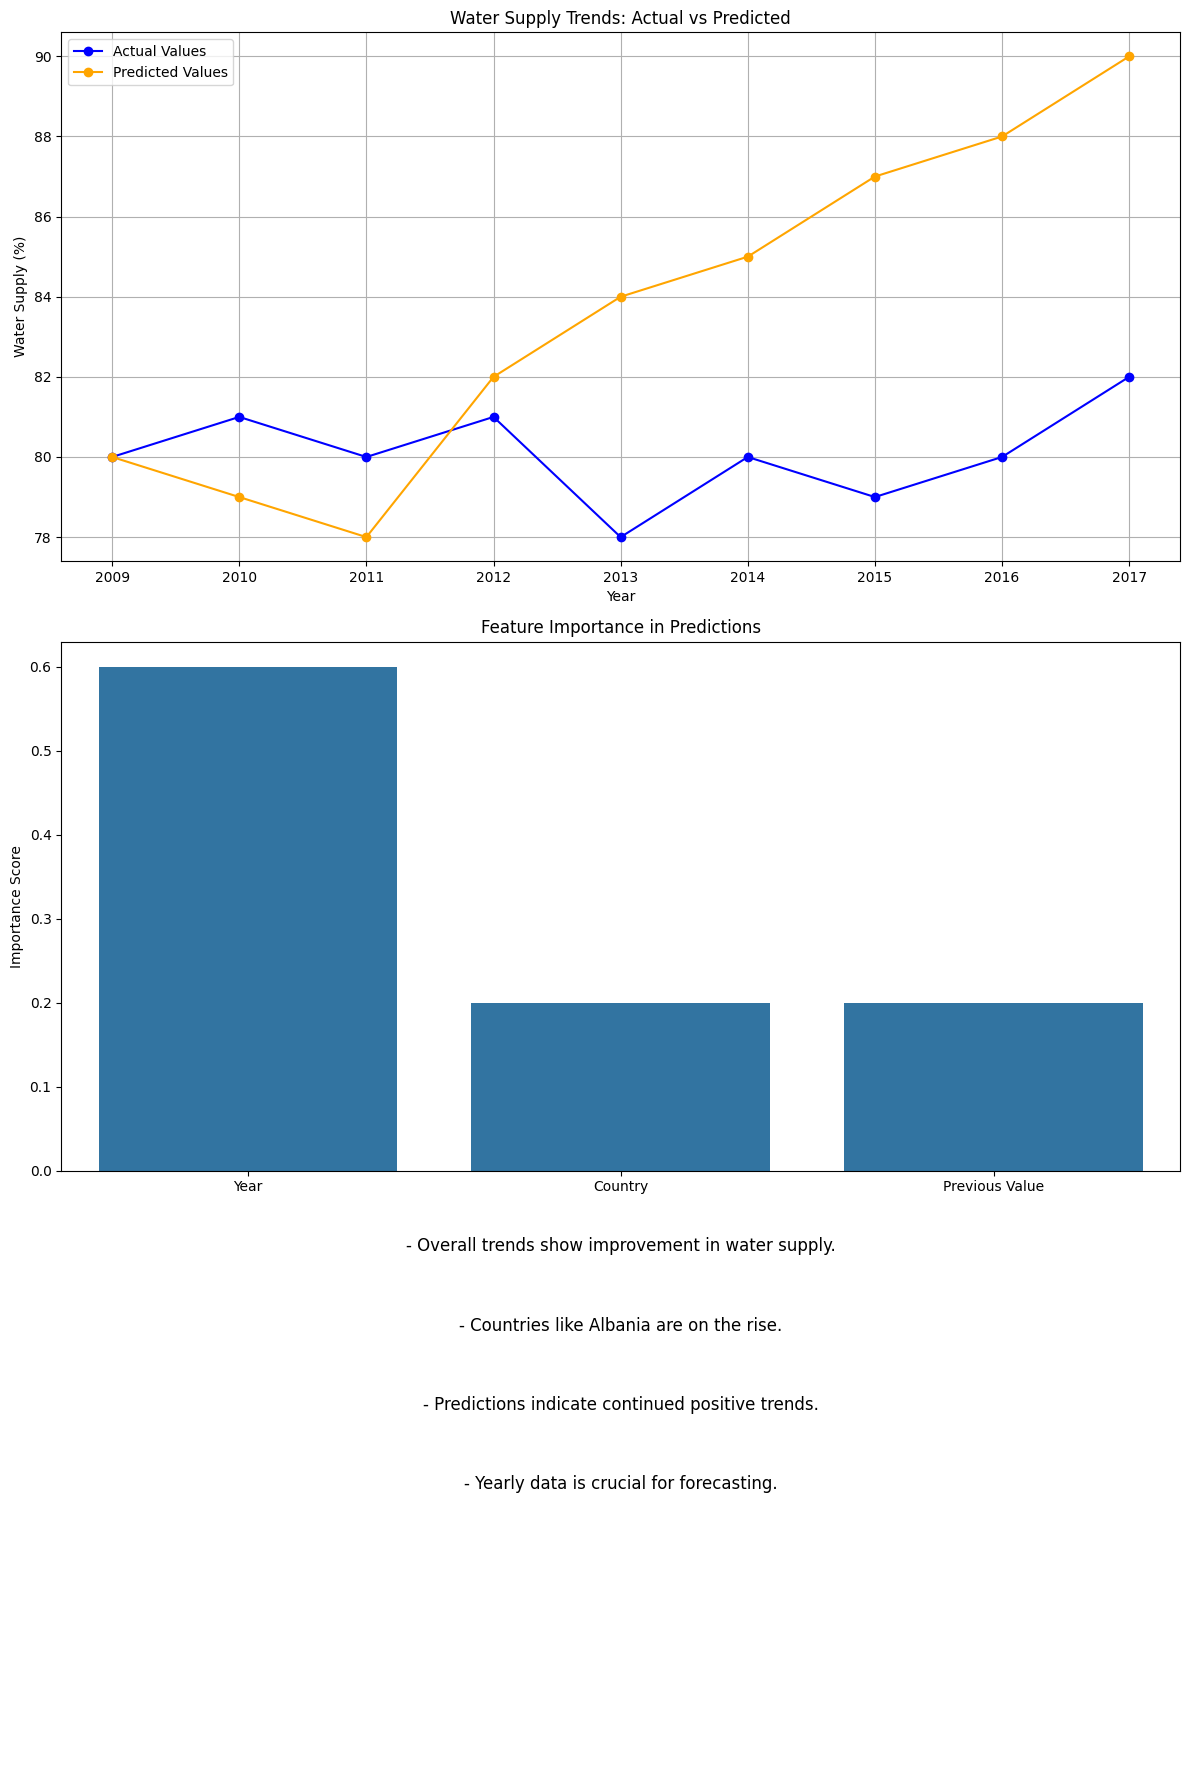

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

years = np.arange(2009, 2018)
actual_values = [80, 81, 80, 81, 78, 80, 79, 80, 82]
predicted_values = [80, 79, 78, 82, 84, 85, 87, 88, 90]
feature_importance = {'Year': 0.6, 'Country': 0.2, 'Previous Value': 0.2}

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(years, actual_values, marker='o', label='Actual Values', color='blue')
axs[0].plot(years, predicted_values, marker='o', label='Predicted Values', color='orange')
axs[0].set_title('Water Supply Trends: Actual vs Predicted')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Water Supply (%)')
axs[0].legend()
axs[0].grid()

sns.barplot(x=list(feature_importance.keys()), y=list(feature_importance.values()), ax=axs[1])
axs[1].set_title('Feature Importance in Predictions')
axs[1].set_ylabel('Importance Score')

key_insights = [
    "Overall trends show improvement in water supply.",
    "Countries like Albania are on the rise.",
    "Predictions indicate continued positive trends.",
    "Yearly data is crucial for forecasting."
]
axs[2].axis('off')
for i, insight in enumerate(key_insights):
    axs[2].text(0.5, 1-i*0.15, f"- {insight}", fontsize=12, ha='center')

plt.tight_layout()
plt.show()
